In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy import stats
#Single CHO cell dry mass: 280 pg/cell. Ref:https://doi.org/10.1016/j.ymben.2021.03.013
#Single mammalian cell dry mass: 264pg/cell. Ref: https://doi.org/10.1016/j.ymben.2020.06.002 

In [2]:
def add_linear(ax, xdata, ydata):
    def func(x, a, b):
        return a * x + b
    popt, pcov = curve_fit(func, xdata, ydata)
    temp_x = np.linspace(min(xdata),max(xdata) )
    ax.plot(temp_x, func(temp_x, *popt),'r--')
    
def get_pv(x,y):
    coeff, pv = stats.pearsonr( x, y)
    return pv

def get_pcc(x,y):
    coeff, pv = stats.pearsonr( x, y)
    return coeff

In [3]:
data_low=pd.read_csv('../data/exp_data/CultureData_lowNH4.csv')
data_low=data_low.rename(columns={'Biomass_avg(g/L)':'Biomass_avg','Biomass_std(g/L)':'Biomass_std'})
data_high=pd.read_csv('../data/exp_data/CultureData_highNH4.csv')
data_high=data_high.rename(columns={'Biomass_avg(g/L)':'Biomass_avg','Biomass_std(g/L)':'Biomass_std'})

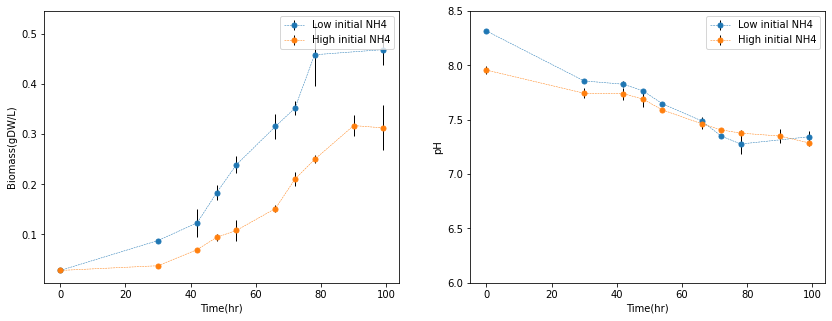

In [4]:
fig,axs=plt.subplots(1,2,figsize=(14,5))
axs[0].errorbar(data_low.Time,data_low.Biomass_avg,yerr= data_low.Biomass_std, ecolor='black',
                      marker='o', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='Low initial NH4')
axs[0].errorbar(data_high.Time,data_high.Biomass_avg,yerr= data_high.Biomass_std, ecolor='black',
                      marker='o', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='High initial NH4')
axs[0].set_ylabel('Biomass(gDW/L)')
axs[1].errorbar(data_low.Time,data_low.pH_avg,yerr= data_low.pH_std, ecolor='black',
                      marker='o', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='Low initial NH4')
axs[1].errorbar(data_high.Time, data_high.pH_avg,yerr= data_high.pH_std, ecolor='black',
                      marker='o', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='High initial NH4')
axs[1].set_ylim([6,8.5])
axs[1].set_ylabel('pH')
for ax in axs:
    ax.legend()
    ax.set_xlabel('Time(hr)')

Text(0, 0.5, 'Concentration (mM)')

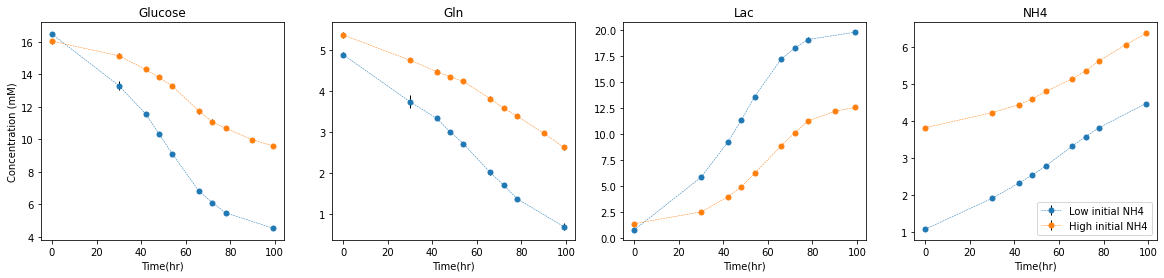

In [5]:
fig, axs = plt.subplots(1,4,figsize=(20,4))
ynames=['Glucose','Gln','Lac','NH4']
for i in range(4):
    axs[i].errorbar(data_low.Time,data_low[ynames[i]+'_avg'],yerr= data_low[ynames[i]+'_std'], ecolor='black',
                      marker='o', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='Low initial NH4')
    axs[i].errorbar(data_high.Time,data_high[ynames[i]+'_avg'],yerr= data_high[ynames[i]+'_std'], ecolor='black',
                      marker='o', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='High initial NH4')
    axs[i].set_xlabel('Time(hr)')
    axs[i].set_title(ynames[i])
axs[3].legend(loc='lower right')
axs[0].set_ylabel('Concentration (mM)')

In [6]:
def get_grs(biomass, time_pts):
    output = []
    for i in range(len(biomass)-1):
        output.append( np.log(biomass[i+1]/biomass[i]) /(time_pts[i+1]-time_pts[i]) )
    return output  
def avg_cons(cons):
    output = []
    for i in range(len(cons)-1):
        output.append( (cons[i+1]+cons[i])/2 )
    return output
def norm_rates(biomass, cons, time_pts):
    output = []
    for i in range(len(biomass)-1):
        output.append( ((cons[i+1]-cons[i])/(biomass[i]/2+biomass[i+1]/2) )/(time_pts[i+1]-time_pts[i]) )
    return output

In [7]:
mets=['Glucose','Gln','Lac','NH4']
Ts= [data_low.Time[i]/2+data_low.Time[i+1]/2 for i in range(len(data_low.Time)-1)]
grs=get_grs(data_low.Biomass_avg, data_low.Time)
approx_low = pd.DataFrame(zip(Ts,grs),columns=['Time','gr'])
for met in mets:
    approx_low[met+'_rate']=norm_rates( data_low.Biomass_avg, data_low[met+'_avg'], data_low.Time)
    approx_low[met+'_conc']=avg_cons( data_low[met+'_avg'] )
Ts=[data_high.Time[i]/2+data_high.Time[i+1]/2 for i in range(len(data_high.Time)-1)]
grs=get_grs(data_high.Biomass_avg, data_high.Time)
approx_high = pd.DataFrame(zip(Ts,grs),columns=['Time','gr'])
for met in mets:
    approx_high[met+'_rate']=norm_rates( data_high.Biomass_avg, data_high[met+'_avg'], data_high.Time)
    approx_high[met+'_conc']=avg_cons( data_high[met+'_avg'] )

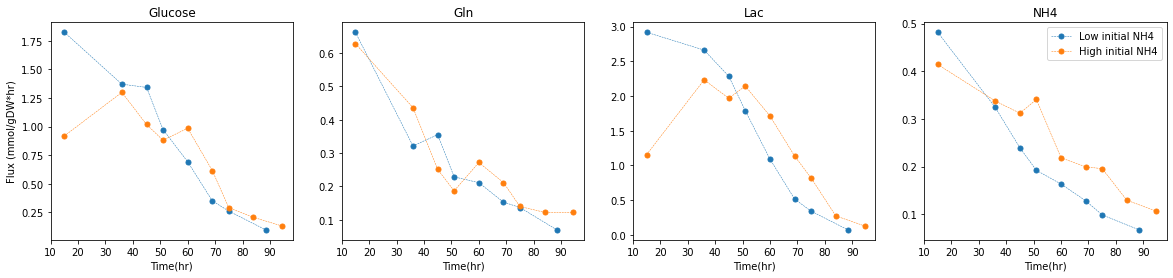

In [8]:
fig, axs = plt.subplots(1,4,figsize=(20,4))
ynames=['Glucose','Gln','Lac','NH4']
for i in range(4):
    if i <2:
        factor=-1
    else:
        factor=1
    axs[i].plot(approx_low.Time, factor*approx_low[ynames[i]+'_rate'],marker='o', markersize=5, 
                linestyle='--', linewidth=0.5,label='Low initial NH4')
    axs[i].plot(approx_high.Time, factor*approx_high[ynames[i]+'_rate'],marker='o', markersize=5, 
                linestyle='--', linewidth=0.5,label='High initial NH4')
    axs[i].set_xlabel('Time(hr)')
    axs[i].set_xticks(np.arange(10,100,10))
    axs[i].set_title(ynames[i])
axs[0].set_ylabel('Flux (mmol/gDW*hr)')
axs[3].legend(loc='upper right')

(0.5, 2.0)

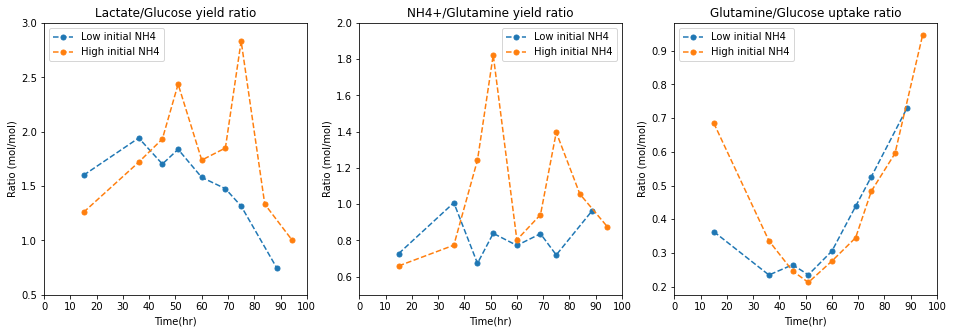

In [12]:
fig,axs = plt.subplots(1,3,figsize=(16,5))
axs[0].plot(approx_low.Time,-1*approx_low.Lac_rate/approx_low.Glucose_rate,marker='o', 
            markersize=5, linestyle='--',label='Low initial NH4')
axs[0].plot(approx_high.Time,-1*approx_high.Lac_rate/approx_high.Glucose_rate,marker='o', 
            markersize=5, linestyle='--',label='High initial NH4')
axs[0].set_title('Lactate/Glucose yield ratio')
axs[1].plot(approx_low.Time,-1*approx_low.NH4_rate/approx_low.Gln_rate,marker='o', 
            markersize=5, linestyle='--',label='Low initial NH4')
axs[1].plot(approx_high.Time,-1*approx_high.NH4_rate/approx_high.Gln_rate,marker='o', 
            markersize=5, linestyle='--',label='High initial NH4')
axs[1].set_title('NH4+/Glutamine yield ratio')

axs[2].plot(approx_low.Time,approx_low.Gln_rate/approx_low.Glucose_rate,marker='o', 
            markersize=5, linestyle='--',label='Low initial NH4')
axs[2].plot(approx_high.Time,approx_high.Gln_rate/approx_high.Glucose_rate,marker='o', 
            markersize=5, linestyle='--',label='High initial NH4')
axs[2].set_title('Glutamine/Glucose uptake ratio')
for ax in axs:
    ax.set_xlabel('Time(hr)')
    ax.legend()
    ax.set_xticks(np.arange(0,110,10))
    ax.set_ylabel('Ratio (mol/mol)')
axs[0].set_ylim([0.5,3.0])
axs[1].set_ylim([0.5,2.0])

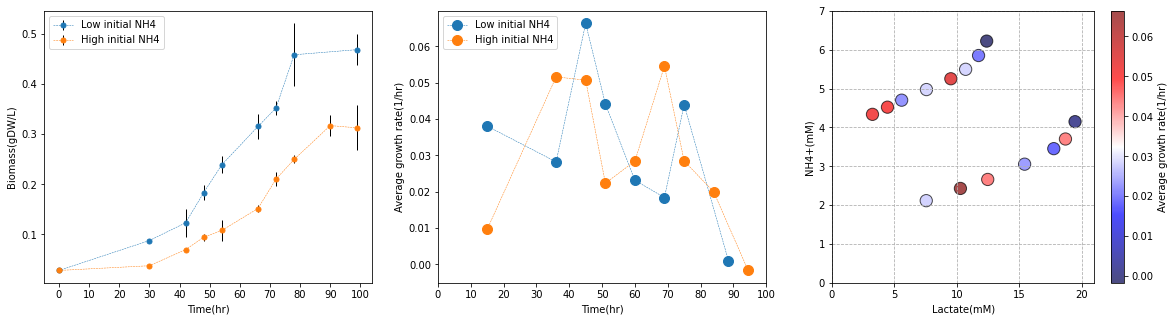

In [11]:
fig, axs = plt.subplots(1,3,figsize=(20,5))
axs[0].errorbar(data_low.Time,data_low.Biomass_avg,yerr= data_low.Biomass_std, ecolor='black',
                      marker='o', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='Low initial NH4')
axs[0].errorbar(data_high.Time,data_high.Biomass_avg,yerr= data_high.Biomass_std, ecolor='black',
                      marker='o', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='High initial NH4')
axs[0].set_ylabel('Biomass(gDW/L)')
axs[1].plot(approx_low.Time,approx_low.gr,marker='o', markersize=10, linestyle='--', 
            linewidth=0.5, label='Low initial NH4')
axs[1].plot(approx_high.Time,approx_high.gr,marker='o', markersize=10, linestyle='--', 
            linewidth=0.5,label='High initial NH4')
axs[1].set_ylabel('Average growth rate(1/hr)')
grs = list(approx_low['gr'])[1:]+list(approx_high['gr'])[1:]
pt1=axs[2].scatter( list(approx_low['Lac_conc'])[1:]+list(approx_high['Lac_conc'])[1:], 
                   list(approx_low['NH4_conc'])[1:]+list(approx_high['NH4_conc'])[1:], c=grs, 
                   cmap='seismic',alpha=0.7,s=150, edgecolor='black')
plt.colorbar(pt1, label='Average growth rate(1/hr)')
axs[2].set_xlabel('Lactate(mM)'); axs[2].set_ylabel('NH4+(mM)')
axs[2].grid(ls='--'); axs[2].set_xlim([0,21.0]); axs[2].set_ylim([0,7.0]);
for ax in axs[:2]:
    ax.set_xlabel('Time(hr)')
    ax.set_xticks(np.arange(0,110,10))
    ax.legend(loc='upper left')

Text(2.5, 0.01, 'p-value>0.05')

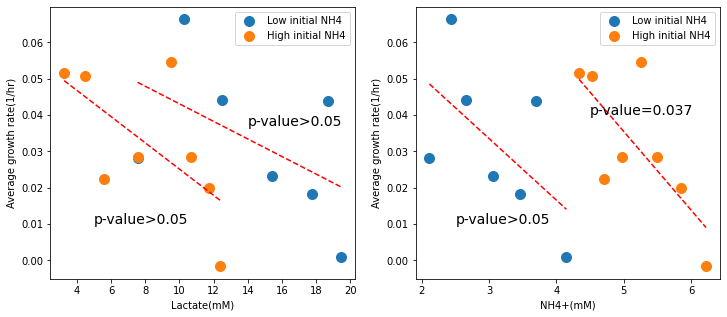

In [31]:
fig,axs=plt.subplots(1,2,figsize=(12,5))
axs[0].scatter(list(approx_low['Lac_conc'])[1:],list(approx_low['gr'])[1:],marker='o', s=100,label='Low initial NH4')
axs[0].scatter(list(approx_high['Lac_conc'])[1:],list(approx_high['gr'])[1:],marker='o', s=100,label='High initial NH4')

add_linear(axs[0], list(approx_low['Lac_conc'])[1:],list(approx_low['gr'])[1:])
add_linear(axs[0], list(approx_high['Lac_conc'])[1:],list(approx_high['gr'])[1:])
axs[1].scatter(list(approx_low['NH4_conc'])[1:], list(approx_low['gr'])[1:],marker='o', s=100,label='Low initial NH4')
axs[1].scatter(list(approx_high['NH4_conc'])[1:], list(approx_high['gr'])[1:],marker='o', s=100,label='High initial NH4')
add_linear(axs[1], list(approx_low['NH4_conc'])[1:],list(approx_low['gr'])[1:])
add_linear(axs[1], list(approx_high['NH4_conc'])[1:],list(approx_high['gr'])[1:])
for ax in axs:
    ax.set_ylabel('Average growth rate(1/hr)')
    ax.legend()
axs[0].set_xlabel('Lactate(mM)'); axs[1].set_xlabel('NH4+(mM)');
axs[0].text(5,0.01,s='p-value>0.05',fontsize=14)
axs[0].text(14,0.037,s='p-value>0.05',fontsize=14)
axs[1].text(4.5,0.04,s='p-value=0.037',fontsize=14)
axs[1].text(2.5,0.01,s='p-value>0.05',fontsize=14)

In [27]:
get_pv(list(approx_high['Lac_conc'])[1:],list(approx_high['gr'])[1:])

0.08576398616796053

In [26]:
ATP_approx_low, ATP_approx_high=[],[]
for i in range(len(approx_low.index)):
    lac_r=approx_low.Lac_rate[i];glc_r=(-1)*approx_low.Glucose_rate[i];gln_r=(-1)*approx_low.Gln_rate[i];
    ATP_approx_low.append( lac_r + max(0,(glc_r-lac_r/2))*36 )
for i in range(len(approx_high.index)):
    lac_r=approx_high.Lac_rate[i];glc_r=(-1)*approx_high.Glucose_rate[i];gln_r=(-1)*approx_high.Gln_rate[i];
    ATP_approx_high.append( lac_r + max(0,(glc_r-lac_r/2))*36 )
    
approx_low['ATP_estimated']=ATP_approx_low
approx_high['ATP_estimated']=ATP_approx_high

In [27]:
temp_grs = list(approx_low.gr[1:5]) + list(approx_high.gr[1:5])
temp_atp = list(approx_low.ATP_estimated[1:5]) + list(approx_high.ATP_estimated[1:5])
def func(x, a, b):
    return a * x + b
popt, pcov = curve_fit(func, temp_grs, temp_atp)
print(popt)

[91.50854735  2.01515865]


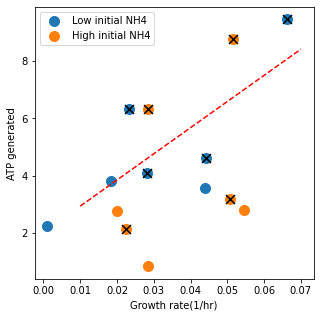

In [31]:
temp_grs = list(approx_low.gr[1:5]) + list(approx_high.gr[1:5])
temp_atp = list(approx_low.ATP_estimated[1:5]) + list(approx_high.ATP_estimated[1:5])
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.scatter(approx_low.gr[1:],approx_low.ATP_estimated[1:],s=100,label='Low initial NH4')
ax.scatter(approx_high.gr[1:-1],approx_high.ATP_estimated[1:-1],s=100,label='High initial NH4')
ax.scatter(temp_grs, temp_atp,s=80,marker='x',color='black')
ax.set_ylabel('ATP generated')
ax.set_xlabel('Growth rate(1/hr)')

temp_x = np.linspace(0.01,0.07)
ax.plot(temp_x, func(temp_x, *popt),'r--')
y_pred = [func(x, 91.508, 2.015) for x in temp_grs]
ax.legend();

In [17]:
temp_grs = list(approx_low.gr)[5:]+list(approx_high.gr)[5:-1]
temp_atp = list(approx_low.ATP_estimated)[5:]+list(approx_high.ATP_estimated)[5:-1]
temp_lac = list(approx_low.Lac_conc)[5:]+list(approx_high.Lac_conc)[5:-1]
temp_nh4 = list(approx_low.NH4_conc)[5:]+list(approx_high.NH4_conc)[5:-1]
ngam = [temp_atp[i]-91.5*temp_grs[i] for i in range(len(temp_grs))]

In [18]:
ngam

[2.124688052358951,
 -0.47620376418047305,
 2.1312119297632264,
 -2.2044468414853897,
 -1.783672892918705,
 0.9148106505929354]